In [130]:
import pandas as pd
import numpy as np
import pyarc
import fim

tracks=pd.read_csv("C:/Users/Vincent/Downloads/COMP4710_project/COMP4710_project/my_dataset.csv",encoding='latin1')

#Remove the common words
words=['i','you','they','we','he','she','it','a','and','the','to','me','not','in','of','on','about','your','that','do','am','for','no','here','there','oh','my','is','are']
indices=np.empty([1],dtype='int64')
for word in words:
    temp=np.concatenate((indices,tracks[tracks['word']==word].index.values))
    indices=temp
tracks2=tracks.drop(index=indices[1:])

#Remove the words that only appear once
singletons=tracks2.groupby('word').sum('count')
bbb=singletons[singletons['count']==1].index.get_level_values(0)
indices=np.empty([1],dtype='int64')
for word in bbb:
    temp=np.concatenate((indices,tracks[tracks['word']==word].index.values))
    indices=temp
tracks3=tracks2.drop(indices[1:])

#Combine the words for each song into 1 list
all_tracks = [track[1]['word'].tolist() for track in list(tracks3.groupby(['track_id','title']))]
lyrics = [track[1]['genre'].tolist()[0] for track in list(tracks3.groupby(['track_id','title']))]
lyrics = pd.DataFrame(lyrics, columns = ["genre"])
lyrics["words"] = all_tracks

#Encode genres into digits (0 to 9)
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
lyrics['genre']=le.fit_transform(lyrics['genre'])

for i in range(len(lyrics.index)):
    lyrics['words'][i].insert(0,str(lyrics['genre'][i]))
    
#Separate the dataset by each genre
lyr=[lyrics[lyrics['genre']==0]['words'],
     lyrics[lyrics['genre']==1]['words'],
     lyrics[lyrics['genre']==2]['words'],
     lyrics[lyrics['genre']==3]['words'],
     lyrics[lyrics['genre']==4]['words'],
     lyrics[lyrics['genre']==5]['words'],
     lyrics[lyrics['genre']==6]['words'],
     lyrics[lyrics['genre']==7]['words'],
     lyrics[lyrics['genre']==8]['words'],
     lyrics[lyrics['genre']==9]['words']]


#Encode the dataset into vertical transaction vector
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()

dfs=[]
for item in lyr:
    te_ary=te.fit(item).transform(item)
    dfs.insert(len(dfs),pd.DataFrame(te_ary,columns=te.columns_))

from mlxtend.frequent_patterns import apriori

#Utilize apriori to mine frequent patterns from each genre and combine them into 1 big dataset
apps=[]
for df in dfs:
    inss=apriori(df, min_support=0.1,use_colnames=True)
    inss=inss.drop(0)
    #inss['support']=inss['support']*len(df)/10000
    apps.insert(len(apps),inss)
apps=pd.concat(apps)

#Select the frequent patterns that contain the genre
digitonly=[s for s in apps['itemsets'] for x in s if x.isdigit()]
digits=apps[apps['itemsets'].isin(digitonly)]

Convert to association rules

In [131]:
from mlxtend.frequent_patterns import association_rules
ar=association_rules(digits,support_only=True,metric='support',min_threshold=0)

Select the unique association rules for each genre that has the best support

In [132]:
digitonly=[s for s in ar['consequents'] for x in s if x.isdigit()]
newset=ar[ar['consequents'].isin(digitonly)][['antecedents','consequents','support']]
newset["consequent_len"] = newset["consequents"].apply(lambda x: len(x))
genre_only=newset[newset['consequent_len']==1]

In [133]:
inp_df=pd.DataFrame()

non_dupes=genre_only.sort_values('support',ascending=False).drop_duplicates('antecedents')
inp_df['antecedents']=non_dupes['antecedents']
conslist=non_dupes["consequents"].apply(lambda x: int(list(x)[0]))
inp_df['consequents']=le.inverse_transform(conslist)

In [134]:
inp_df

,antecedents,consequents
614150,(so),soul
613913,(be),soul
614043,(know),soul
59273,(but),country
613891,(all),soul
...,...,...
84095,"(was, away, so)",country
83731,"(out, would, at)",country
139200,"(was, up, all, just)",country
83970,"(away, but, like)",country


In [135]:
import collections
counter = collections.Counter(inp_df['consequents'])
counter

Counter({'soul': 79890,
         'country': 1626,
         'metal': 434,
         'punk': 230,
         'blues': 280,
         'folk': 157,
         'pop': 37,
         'jazz': 21,
         'electronic': 2,
         'rock': 1})

Since rock only has 1 instance, and electronic only has 2, we will remove rock and electronic from the possible classes to predict

In [136]:
inp_df=inp_df.drop(inp_df[inp_df['consequents']=='rock'].index)
inp_df=inp_df.drop(inp_df[inp_df['consequents']=='electronic'].index)

Convert the dataset back to vertical transaction vector form

In [137]:
te2=TransactionEncoder()
rearranged=te2.fit(inp_df['antecedents']).transform(inp_df['antecedents'])
X=pd.DataFrame(rearranged,columns=te2.columns_)
y=inp_df['consequents']

In [138]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [139]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)

from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test,y_pred)

0.5420204450180587

In [140]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier()
sgd.fit(X_train,y_train)
y_pred=sgd.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.29889171490325783

In [141]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.6064667549669382

In [142]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.5644140332846683

In [143]:
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.38941608684161344

In [144]:
from sklearn.neighbors import KNeighborsClassifier
knc=KNeighborsClassifier()
knc.fit(X_train,y_train)
y_pred=knc.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.3843744396605239

In [145]:
from sklearn.model_selection import GridSearchCV

parameters={'var_smoothing':[1e-3,1e-2,1e-1,1.75e-1,1.8e-1,1.85e-1,1]}
gs_gauss=GridSearchCV(gnb,parameters,scoring="balanced_accuracy")
gs_gauss.fit(X_train,y_train)
gs_gauss.best_estimator_

GaussianNB(var_smoothing=0.175)

In [146]:
newgnb=gs_gauss.best_estimator_
newgnb.fit(X_train,y_train)
y_pred=newgnb.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.7766621692799153

In [147]:
parameters={'n_estimators': [100,200,500],
            'max_features': ['sqrt','log2'],
            'max_depth' : [4,5,None],
            'criterion' :['gini','entropy']}
gs_forest=GridSearchCV(rf,parameters,scoring="balanced_accuracy",cv=3)
gs_forest.fit(X_train,y_train)
gs_forest.best_estimator_

RandomForestClassifier(random_state=42)

In [148]:
newrf=gs_forest.best_estimator_
newrf.fit(X_train,y_train)
y_pred=newrf.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.5644140332846683

In [149]:
parameters={'max_features': ['sqrt','log2'],
            'max_depth' : [4,5,None],
            'criterion' :['gini','entropy'],
            'splitter':['best','random']}
gs_tree=GridSearchCV(tree,parameters,scoring="balanced_accuracy",cv=3)
gs_tree.fit(X_train,y_train)
gs_tree.best_estimator_

DecisionTreeClassifier(max_features='sqrt', random_state=42)

In [150]:
newtree=gs_tree.best_estimator_
newtree.fit(X_train,y_train)
y_pred=newtree.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.612540593808673

Examine the metrics (precision,recall,F score) for the finished model compared to the default Gaussian Naive Bayes model before hyperparameter tuning

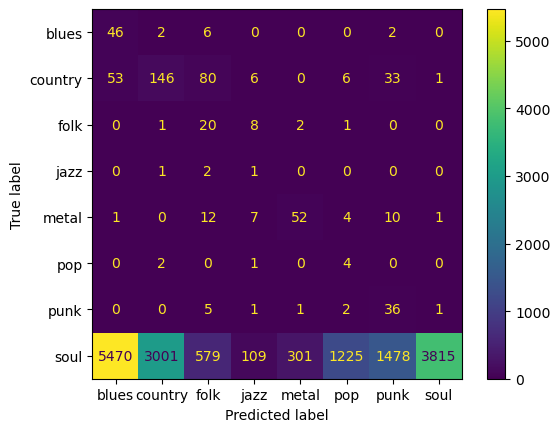

In [151]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix,f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_pre=gnb.predict(X_test)
y_pred_post=newgnb.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred_pre), display_labels=gnb.classes_)
disp.plot()
plt.show()

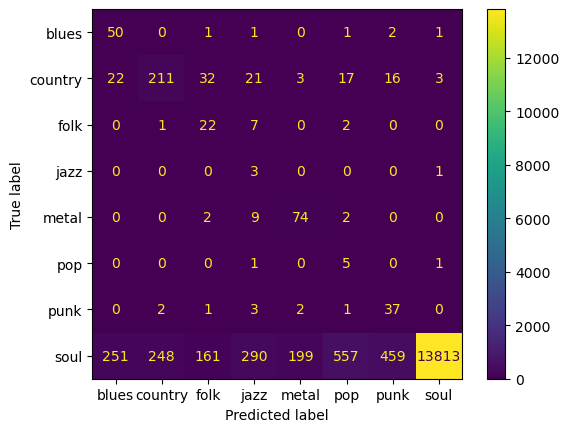

In [152]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred_post), display_labels=newgnb.classes_)
disp.plot()
plt.show()

In [153]:
precision_score(y_test,y_pred_pre,average='weighted')

0.9673836523318672

In [154]:
precision_score(y_test,y_pred_post,average='weighted')

0.9771963641254494

In [155]:
recall_score(y_test,y_pred_pre,average='weighted')

0.24916843060175387

In [156]:
recall_score(y_test,y_pred_post,average='weighted')

0.8596915633504687

In [157]:
f1_score(y_test,y_pred_pre,average='weighted')

0.3756247202639567

In [158]:
f1_score(y_test,y_pred_post,average='weighted')

0.9101933449931754

For random forest

In [159]:
y_pred_pre=rf.predict(X_test)
y_pred_post=newrf.predict(X_test)

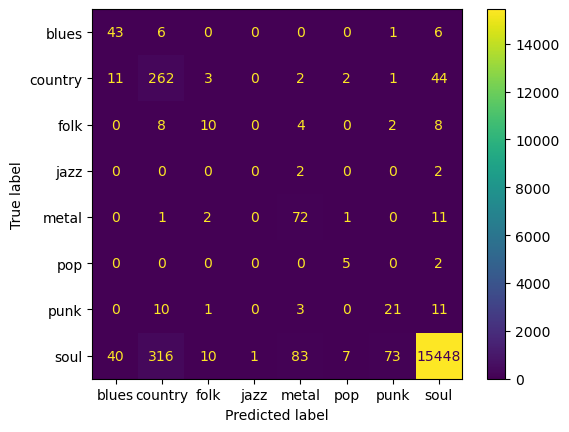

In [173]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred_pre), display_labels=gnb.classes_)
disp.plot()
plt.show()

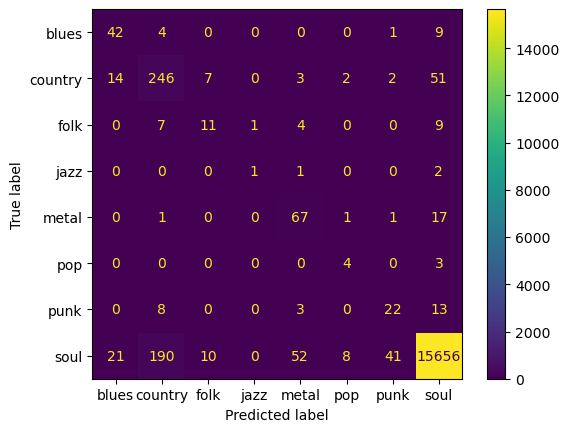

In [174]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred_post), display_labels=newgnb.classes_)
disp.plot()
plt.show()

In [160]:
precision_score(y_test,y_pred_pre,average='weighted')

C:\Users\Vincent\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9809836140743274

In [161]:
precision_score(y_test,y_pred_post,average='weighted')

C:\Users\Vincent\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9809836140743274

In [162]:
recall_score(y_test,y_pred_pre,average='weighted')

0.9809495010583611

In [163]:
recall_score(y_test,y_pred_post,average='weighted')

0.9809495010583611

In [164]:
f1_score(y_test,y_pred_pre,average='weighted')

0.9807381357363991

In [165]:
f1_score(y_test,y_pred_post,average='weighted')

0.9807381357363991

For decision tree

In [166]:
y_pred_pre=tree.predict(X_test)
y_pred_post=newtree.predict(X_test)

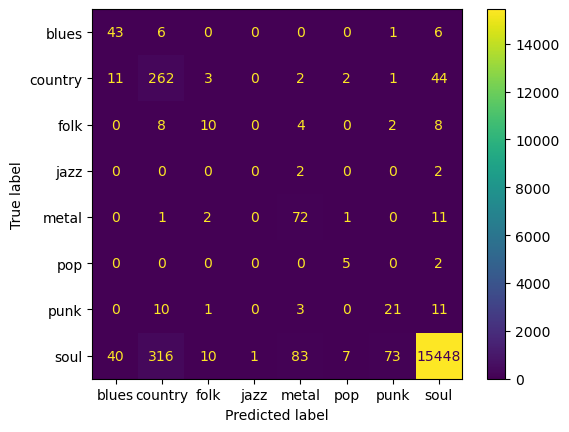

In [175]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred_pre), display_labels=gnb.classes_)
disp.plot()
plt.show()

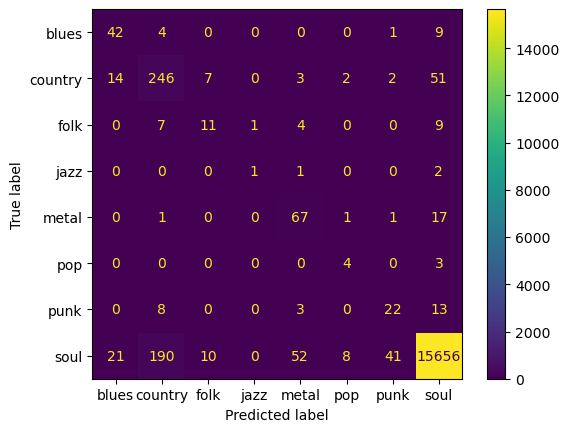

In [176]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred_post), display_labels=newgnb.classes_)
disp.plot()
plt.show()

In [167]:
precision_score(y_test,y_pred_pre,average='weighted')

0.9749409549800893

In [168]:
precision_score(y_test,y_pred_post,average='weighted')

0.9770073696777847

In [169]:
recall_score(y_test,y_pred_pre,average='weighted')

0.9592379800423344

In [170]:
recall_score(y_test,y_pred_post,average='weighted')

0.9706078016329

In [171]:
f1_score(y_test,y_pred_pre,average='weighted')

0.9651905050612154

In [172]:
f1_score(y_test,y_pred_post,average='weighted')

0.9731412170456238